In [1]:
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from sklearn.feature_extraction.text import CountVectorizer



## Load the Data:
* Load the BBC Test Data
* Use the TF-IDF Method to vectorize the text
* Inspect the Data to understand the dataframe Layout
* Visualize the Sample Vectorized Data

We will use Term Frequency - Inverse Document Frequency (TF-IDF). It allows for realtive importance measure of a word in a document compared to multiple other documents. Tne intent is, it will help issolate (give higher importance) to words that are specific to an article and lower weights to those found across multiple articles. Here the sklearns TfidfVectorizer is used to achive the TF-IDF.

In [6]:
X_test = pd.read_csv('data/BBC_News_data/BBC_News_Test.csv')
y_test = pd.read_csv('data/BBC_News_data/BBC_News_Sample_Solution.csv')
X_train = pd.read_csv('data/BBC_News_data/BBC_News_Train.csv')
y_train = X_train.Category
X_test = X_test.Text
X_train = X_train.Text

catagories = y_train.unique()
no_catefories = len(catagories)

print(X_test)
print(X_train.info())

TypeError: Cannot interpret '<module 'string' from 'c:\\Users\\Umakaran Nemallan\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\string.py'>' as a data type

## Analyse the Dataframes loaded
* look at number of samples per category
* Look for any obvious patterns 

Category Counts in the Training Data
Category
sport            346
business         336
politics         274
entertainment    273
tech             261
Name: count, dtype: int64
Category Counts Plot


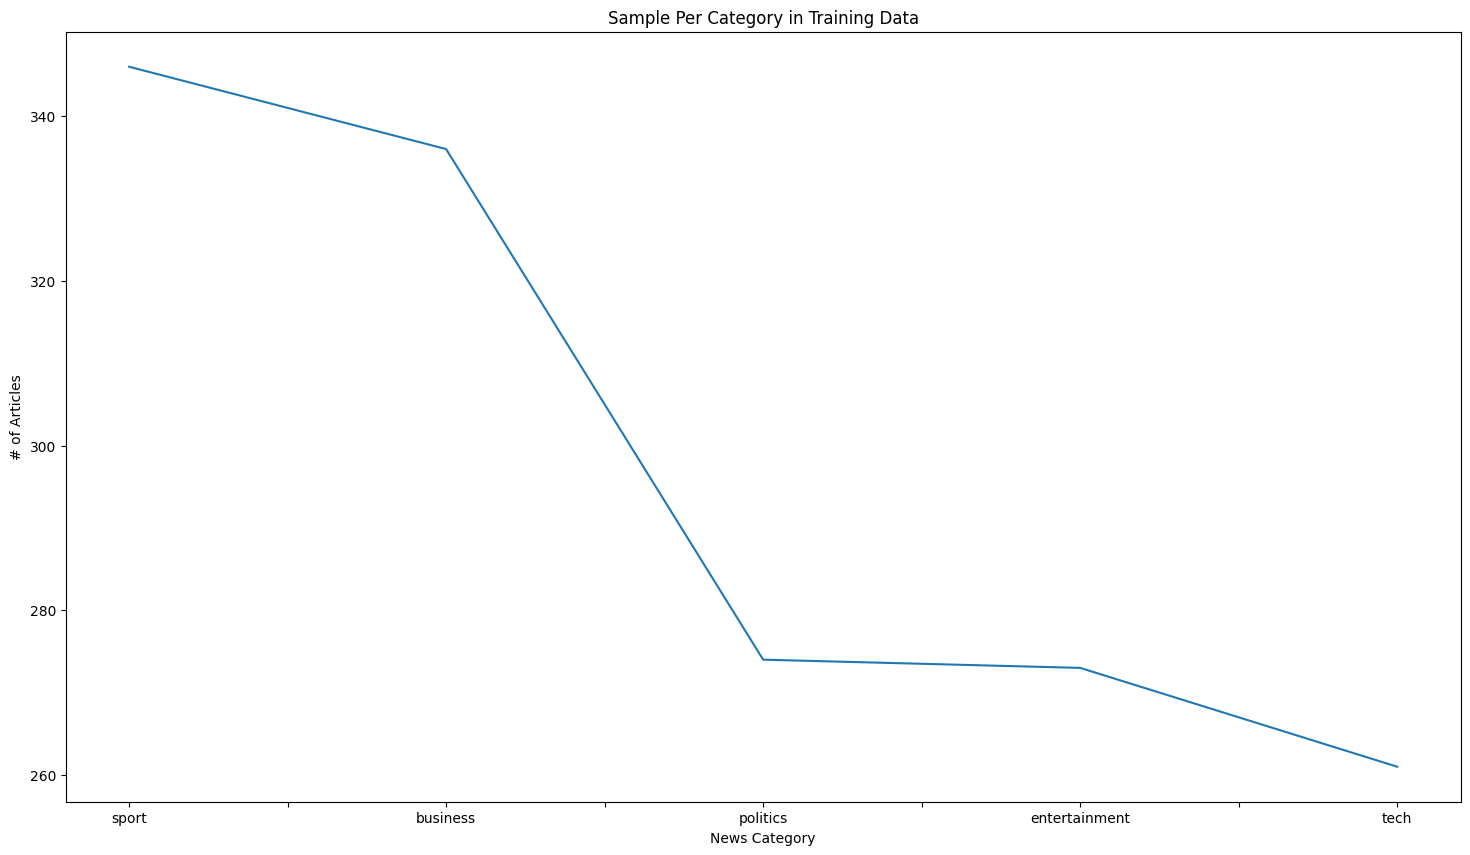

In [3]:
category_counts = y_train.value_counts()
print ("Category Counts in the Training Data")
print (category_counts)

print ("Category Counts Plot")
plt.figure(figsize=(18, 10))
category_counts.plot()
plt.title('Sample Per Category in Training Data')
plt.xlabel('News Category')
plt.ylabel('# of Articles')
plt.show()


## Observations from the Graph
* We can see that there is a reasonably even distribution of samples per category (Difference between Sports to Tech interms of training sample, its only 25% smaller)
* This means we will prevent one category from biasing the training

## Look for Common Words, to figure out what can be ommitied from the training data. 

the     34992
to      16568
of      12970
and     12366
a       12102
in      11696
s        5899
for      5773
is       5478
that     5207
it       5000
on       4991
was      4019
he       3866
be       3803
with     3482
said     3401
has      3250
as       3245
have     3133
at       3032
by       2969
will     2962
but      2902
are      2840
i        2392
from     2382
not      2210
-        2125
they     2059
mr       1969
his      1967
an       1872
we       1857
this     1794
Name: count, dtype: int64


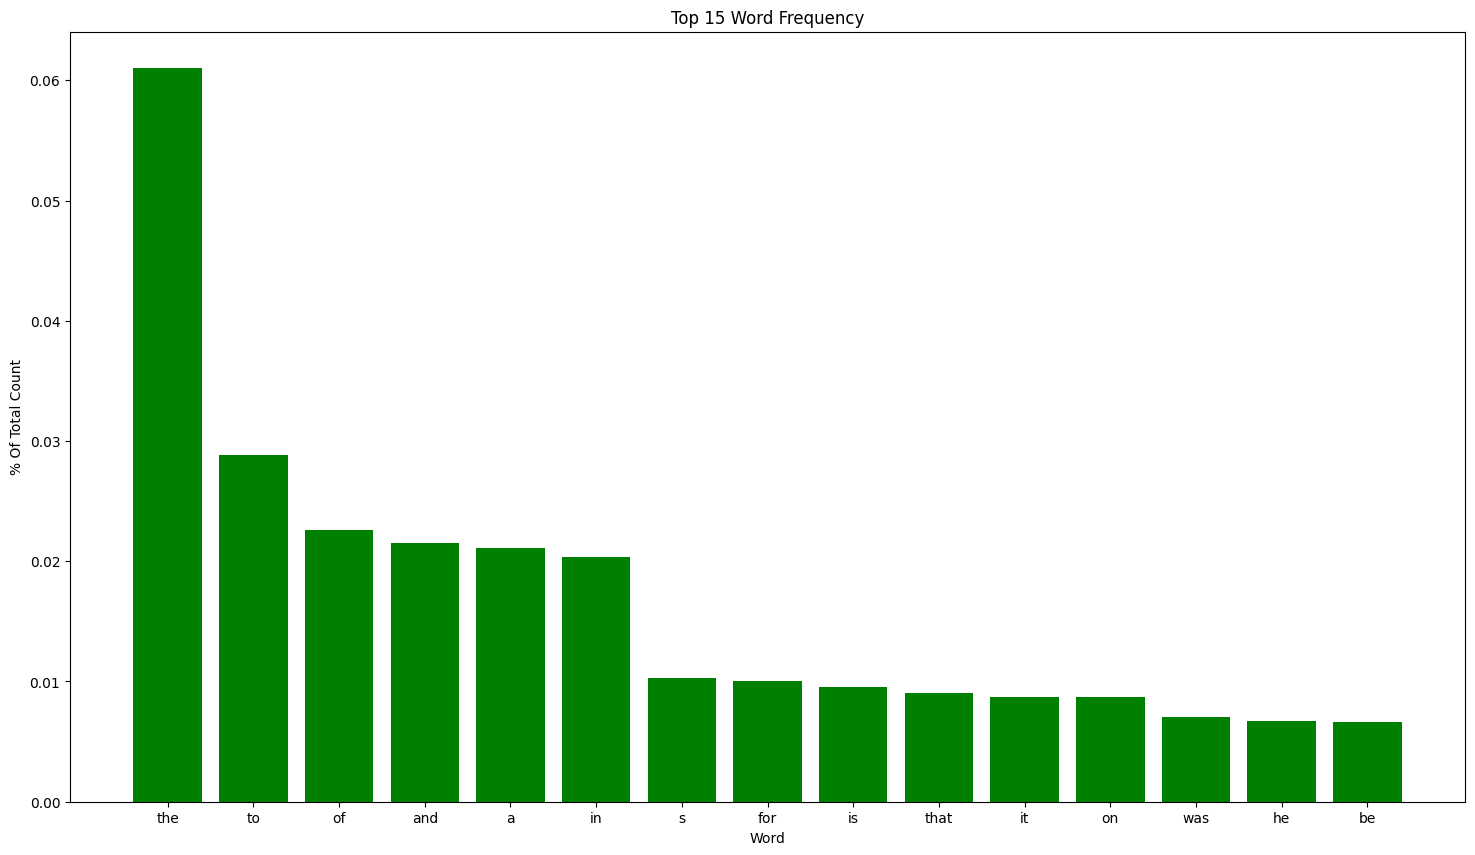

In [4]:
# Based on : https://programminghistorian.org/en/lessons/counting-frequencies
# Look at occurances of words in the dataset

word_frq = X_train.str.split(expand=True).unstack().value_counts()
frq_plot = word_frq[:15] / np.sum(word_frq)
print (word_frq[:35] )
plt.figure(figsize=(18, 10))
plt.bar(frq_plot.index, frq_plot.values, color='Green')
plt.title('Top 15 Word Frequency')
plt.xlabel('Word')
plt.ylabel('% Of Total Count')
plt.show()

## Word Frequecy Based Data Cleaning
* We can see from the Word Count, after the fift word the numbe of samples in the data drops to below 0.01% of the sample size
* 5 words that dominate the sample size (the, to, of, and, a, in) Are stopwords and would not add any unique information to the trainning so we can remove them
* We will remove digits, and punctiations as well
* We will use NLTK to remove stop words and use TI/IDF to vectorize the remaining words
* We should also note, the words Said seems to be very common in this data set, which is genrally not a stop word, lets remove that out as well

# Create a Model
For this case, we need to use SVD for categorization, so we will use Sklearn's SVD fundtion to categorizat the test data.



In [14]:
def remove_stop_words(doc):
    text = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    tokens = wordpunct_tokenize(text)
    _filtered_words = [word for word in tokens if word.lower() not in stopwords.words('english')]
    return ' '.join(_filtered_words)

X_train['clean_text'] = X_train.apply(lambda x: remove_stop_words(x))
X_test['clean_text'] = X_test.apply(lambda x: remove_stop_words(x))

C:\Users\Umakaran Nemallan\AppData\Local\Temp\ipykernel_1096\890706306.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['clean_text'] = X_train.apply(lambda x: remove_stop_words(x))


TypeError: 'in <string>' requires string as left operand, not int

In [77]:
processed_training_data = X_train['clean_text'].tolist()
processed_test_data = X_train['clean_text'].tolist()

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, min_df=2, stop_words='english')
tfidf_train_matrix = tfidf_vectorizer.fit_transform(processed_training_data)
tfidf_test_matrix = tfidf_vectorizer.fit_transform(processed_test_data)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

In [79]:
#build the SVD Model
svd = TruncatedSVD(n_components=5, n_iter=7, random_state=42)
svd.fit(tfidf_train_matrix)
predictions =  svd.transform(tfidf_test_matrix)
print (predictions)

[[ 0.11923883  0.03400216  0.0427328  -0.00151827  0.05051354]
 [ 0.15675661 -0.01535908  0.12769602 -0.02902585  0.22970057]
 [ 0.1911975  -0.00808453  0.07155877 -0.02683744  0.09544794]
 ...
 [ 0.23407586 -0.15993622  0.22254048  0.04470189 -0.18829356]
 [ 0.09577428 -0.05018656  0.09351539 -0.00981461 -0.09117285]
 [ 0.98011247 -0.15859687  0.0305014  -0.01353662 -0.01515934]]


#References:
* Bird, Steven, Edward Loper and Ewan Klein (2009), Natural Language Processing with Python. O’Reilly Media Inc.
* https://www.geeksforgeeks.org/removing-stop-words-nltk-python/ (How to Use NLPD library to remove Stop Words)
* https://www.learndatasci.com/glossary/tf-idf-term-frequency-inverse-document-frequency/ (How to use tf-idf to vectorize)
* (Code for Word Freq Counting) https://programminghistorian.org/en/lessons/counting-frequencies

In [82]:
from scipy.sparse import coo_matrix
from sklearn.decomposition import NMF

#Load the data following the Week-3 Code
movie_rating = pd.read_csv('data/movie_rating_data/movies.csv')
test_data = pd.read_csv('data/movie_rating_data/test.csv')
train_data = pd.read_csv('data/movie_rating_data/train.csv')
user_rating = pd.read_csv('data/movie_rating_data/users.csv')

#create the rating matrix using week3 code
mid2idx = dict(zip(movie_rating.mID,list(range(len(movie_rating)))))
uid2idx = dict(zip(user_rating.uID,list(range(len(user_rating)))))
allusers = list(user_rating['uID'])
allmovies = list(movie_rating['mID'])

ind_movie = [mid2idx[x] for x in train_data.mID] 
ind_user = [uid2idx[x] for x in train_data.uID]
rating_train = list(train_data.rating)
        
rating_mat= np.array(coo_matrix((rating_train, (ind_user, ind_movie)), shape=(len(allusers), len(allmovies))).toarray())







model = NMF(n_components=2, init='random', random_state=0)
W = model.fit_transform(rating_mat)
H = model.components_
print (H)



[[1.95066494 0.93647134 0.57557876 ... 0.02346859 0.         0.26210754]
 [1.09165879 0.05378824 0.         ... 0.08712599 0.04899218 0.36087141]]
